In [55]:
# Load necessary libraries


library("tidyverse")
library("caret")
library("tseries")
# Load data (replace 'your_data.csv' with your actual file path)
df <- read.csv("/content/BTC-USD.csv")

# Check column names in df
column_names <- names(df)
print(column_names)

# Normalize data (replace 'Open' and 'Close' with your actual variable names)
scaler <- preProcess(df[, c("Open", "Close")], method = c("range"))
normalized_data <- predict(scaler, df[, c("Open", "Close")])

# Build linear regression model (replace 'Close', 'Open', and 'High' with your actual variable names)
linear_model <- lm(Close ~ Open + High, data = cbind(df, normalized_data))

# Check stationarity of time series data (replace 'df$Close' with your actual time series variable)
adf_test_result <- adf.test(df$Close)

# Display results
summary(linear_model)



[1] "Date"      "Open"      "High"      "Low"       "Close"     "Adj.Close"
[7] "Volume"   



Call:
lm(formula = Close ~ Open + High, data = cbind(df, normalized_data))

Residuals:
    Min      1Q  Median      3Q     Max 
-7255.8   -89.1    75.8   219.7  1783.3 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 65.73505   24.24910   2.711  0.00677 ** 
Open        -0.20354    0.02464  -8.260 2.77e-16 ***
High         1.17165    0.02401  48.789  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 664 on 1824 degrees of freedom
Multiple R-squared:  0.9985,	Adjusted R-squared:  0.9985 
F-statistic: 5.961e+05 on 2 and 1824 DF,  p-value: < 2.2e-16


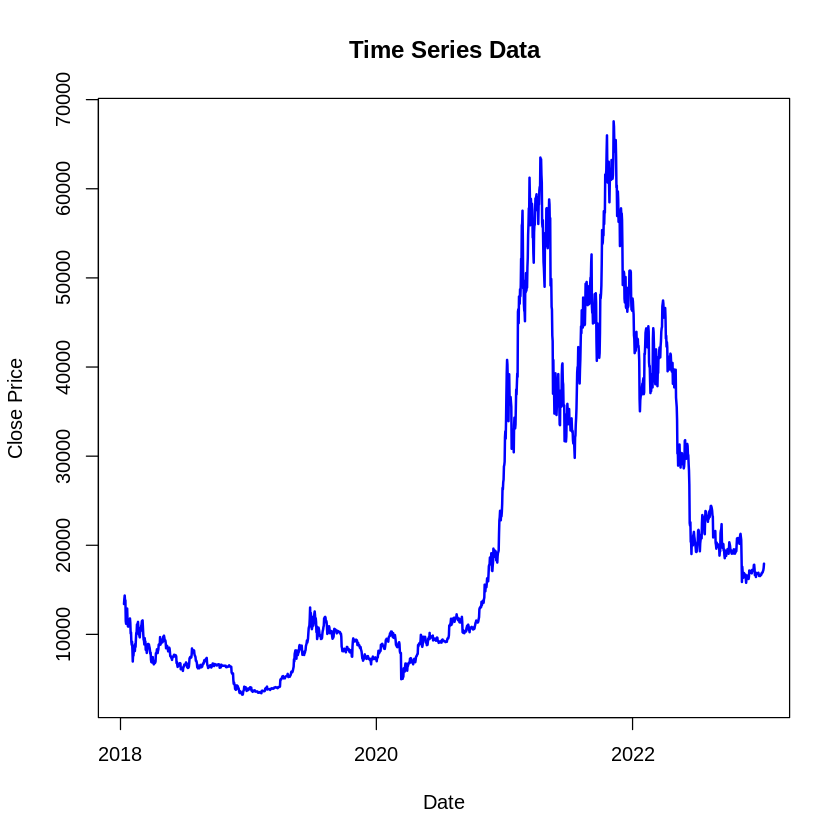

In [56]:
# Set up the plotting area
par(mar = c(5, 4, 4, 2) + 0.1)

# Convert 'Date' to Date type if it's not already
df$Date <- as.Date(df$Date)

# Plot the time series data
plot(df$Date, df$Close, type = 'l', col = 'blue', lwd = 2, xlab = 'Date', ylab = 'Close Price', main = 'Time Series Data')

# Display the plot


In [57]:
# Function to test stationarity using ADF test
adf_test <- function(timeseries) {
  timeseries <- na.omit(timeseries)  # Remove missing values
  result <- adf.test(timeseries, alternative = "stationary", k = trunc((length(timeseries)-1)^(1/3)))

  cat('ADF Statistic:', result$statistic, '\n')
  cat('p-value:', result$p.value, '\n')
  cat('Critical Values:', result$critical, '\n')

  # Check the p-value
  if (result$p.value <= 0.05) {
    cat("Reject the null hypothesis. Data is stationary.\n")
  } else {
    cat("Fail to reject the null hypothesis. Data is non-stationary.\n")
  }
}

# Test the stationarity of the data
adf_test(df$Close)


ADF Statistic: -1.383939 
p-value: 0.8391211 
Critical Values: 
Fail to reject the null hypothesis. Data is non-stationary.


Warning message in adf.test(timeseries, alternative = "stationary", k = trunc((length(timeseries) - :
“p-value smaller than printed p-value”


ADF Statistic: -11.38824 
p-value: 0.01 
Critical Values: 
Reject the null hypothesis. Data is stationary.


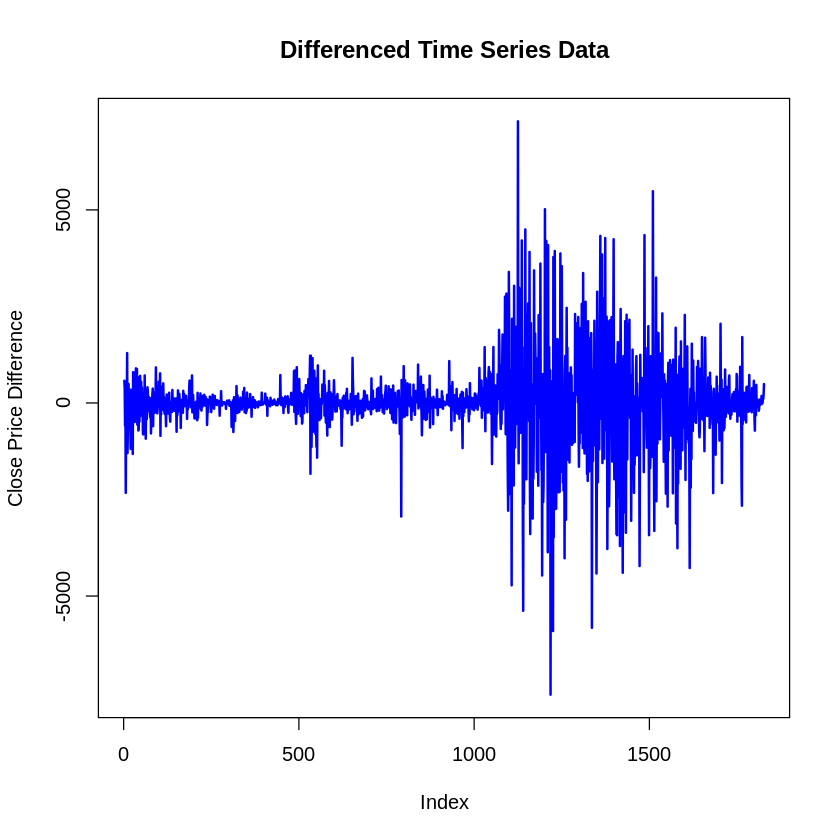

In [58]:
# Take the first difference to make the data stationary
df$Close_diff <- c(NA, diff(df$Close))

# Visualize the differenced data (if needed)
plot(df$Close_diff, type = 'l', col = 'blue', lwd = 2, main = 'Differenced Time Series Data', xlab = 'Index', ylab = 'Close Price Difference')

# Test the stationarity of the differenced data
adf_test(df$Close_diff)


In [59]:
# Split the data into training, testing, and validation sets 6:2:2
train_size <- floor(0.7 * nrow(df))
test_size <- floor(0.2 * nrow(df))
val_size <- nrow(df) - train_size - test_size

train_data <- df[1:train_size, ]
test_data <- df[(train_size + 1):(train_size + test_size), ]
val_data <- df[(train_size + test_size + 1):nrow(df), ]

# Assuming 'Date' is not already a Date type, you might need to convert it using as.Date
# For example: train_data$Date <- as.Date(train_data$Date)

x_train <- as.matrix(train_data$Date)
y_train <- as.vector(train_data$Close)

In [60]:
# Install and load necessary packages
# install.packages("forecast")
library(forecast)

# Fit the auto_arima model
model <- auto.arima(y_train, trace = TRUE)


 Fitting models using approximations to speed things up...

 ARIMA(2,1,2) with drift         : 20888.63
 ARIMA(0,1,0) with drift         : 20899.72
 ARIMA(1,1,0) with drift         : 20892.54
 ARIMA(0,1,1) with drift         : 20893.35
 ARIMA(0,1,0)                    : 20898.17
 ARIMA(1,1,2) with drift         : 20885.25
 ARIMA(0,1,2) with drift         : 20885.4
 ARIMA(1,1,1) with drift         : 20890.99
 ARIMA(1,1,3) with drift         : 20887.25
 ARIMA(0,1,3) with drift         : 20885.76
 ARIMA(2,1,1) with drift         : 20886.98
 ARIMA(2,1,3) with drift         : Inf
 ARIMA(1,1,2)                    : 20883.59
 ARIMA(0,1,2)                    : 20883.85
 ARIMA(1,1,1)                    : 20889.49
 ARIMA(2,1,2)                    : 20886.71
 ARIMA(1,1,3)                    : 20885.59
 ARIMA(0,1,1)                    : 20891.86
 ARIMA(0,1,3)                    : 20884.18
 ARIMA(2,1,1)                    : 20885.32
 ARIMA(2,1,3)                    : Inf

 Now re-fitting the best 

In [61]:
# 4. Testing process
x_test <- as.matrix(test_data$Date)
y_test <- as.vector(test_data$Close)

y_pred <- forecast(model, h = length(y_test))$mean

# 5. Validation process
x_val <- as.matrix(val_data$Date)
y_val <- as.vector(val_data$Close)

y_pred_val <- forecast(model, h = length(y_val))$mean


In [62]:
# 6. Predict closing prices for the next 30 days
last_index <- tail(index(df), 1)
x_next_30_days <- seq(last_index + 1, last_index + 30)
y_next_30_days <- forecast(model, h = 30)$mean

# Print the predicted closing prices for the next 30 days
cat('Predicted closing prices for the next 30 days:\n')
print(y_next_30_days)

# 7. Predict closing prices for the next 100 days
x_next_100_days <- seq(last_index + 1, last_index + 100)
y_next_100_days <- forecast(model, h = 100)$mean

# Print the predicted closing prices for the next 100 days
cat('Predicted closing prices for the next 100 days:\n')
print(y_next_100_days)


Predicted closing prices for the next 30 days:
Time Series:
Start = 1279 
End = 1308 
Frequency = 1 
 [1] 34184.18 34242.58 34272.15 34287.13 34294.71 34298.56 34300.50 34301.49
 [9] 34301.99 34302.24 34302.37 34302.43 34302.46 34302.48 34302.49 34302.49
[17] 34302.49 34302.50 34302.50 34302.50 34302.50 34302.50 34302.50 34302.50
[25] 34302.50 34302.50 34302.50 34302.50 34302.50 34302.50
Predicted closing prices for the next 100 days:
Time Series:
Start = 1279 
End = 1378 
Frequency = 1 
  [1] 34184.18 34242.58 34272.15 34287.13 34294.71 34298.56 34300.50 34301.49
  [9] 34301.99 34302.24 34302.37 34302.43 34302.46 34302.48 34302.49 34302.49
 [17] 34302.49 34302.50 34302.50 34302.50 34302.50 34302.50 34302.50 34302.50
 [25] 34302.50 34302.50 34302.50 34302.50 34302.50 34302.50 34302.50 34302.50
 [33] 34302.50 34302.50 34302.50 34302.50 34302.50 34302.50 34302.50 34302.50
 [41] 34302.50 34302.50 34302.50 34302.50 34302.50 34302.50 34302.50 34302.50
 [49] 34302.50 34302.50 34302.50 34302.

In [63]:
# 7. Evaluate accuracy for validation and test sets
valid_rmse <- sqrt(mean((y_pred_val - y_val)^2))
valid_mae <- mean(abs(y_pred_val - y_val))
valid_mape <- mean(abs((y_pred_val - y_val) / y_val)) * 100

test_rmse <- sqrt(mean((y_pred - y_test)^2))
test_mae <- mean(abs(y_pred - y_test))
test_mape <- mean(abs((y_pred - y_test) / y_test)) * 100

cat('Validation RMSE:', valid_rmse, '\n')
cat('Validation MAE:', valid_mae, '\n')
cat('Validation MAPE:', valid_mape, '\n')

cat('Testing RMSE:', test_rmse, '\n')
cat('Testing MAE:', test_mae, '\n')
cat('Testing MAPE:', test_mape, '\n')


Validation RMSE: 15026.81 
Validation MAE: 14841.73 
Validation MAPE: 78.80631 
Testing RMSE: 13707.43 
Testing MAE: 11426.6 
Testing MAPE: 26.51185 


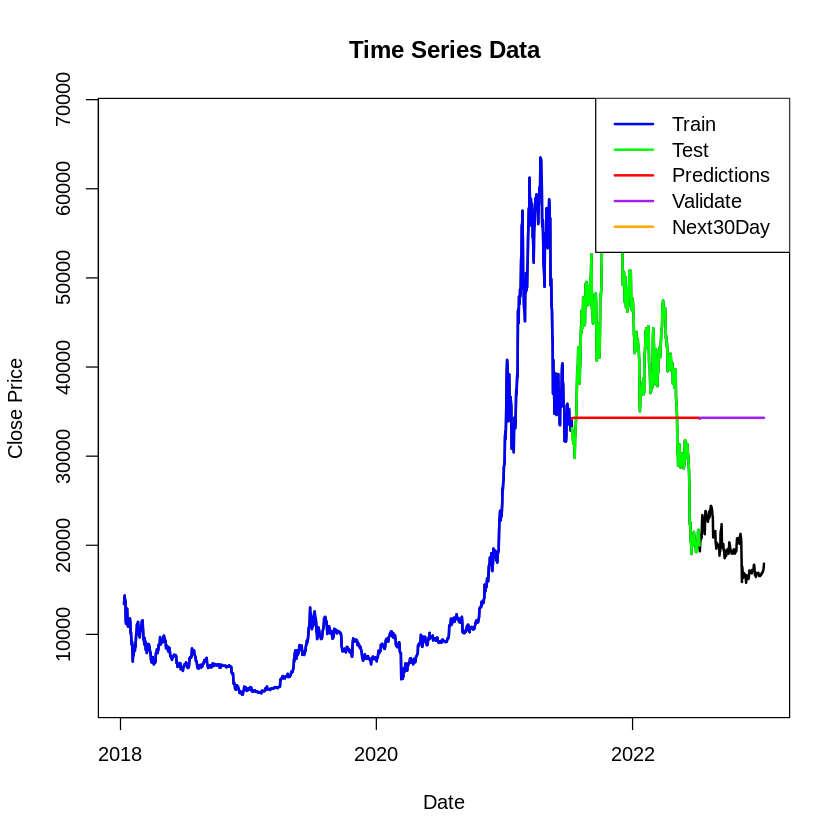

In [64]:
# Assuming 'Date' is your date column
# Assuming 'Close' is your closing price column

# 9. Plot figures
par(mar = c(5, 4, 4, 2) + 0.1)
plot(df$Date, df$Close, type = 'l', col = 'black', lwd = 2, xlab = 'Date', ylab = 'Close Price', main = 'Time Series Data')

lines(train_data$Date, train_data$Close, col = 'blue', lwd = 2)
lines(test_data$Date, test_data$Close, col = 'green', lwd = 2)
lines(test_data$Date, y_pred, col = 'red', lwd = 2)
lines(val_data$Date, y_pred_val, col = 'purple', lwd = 2)
lines(seq(last_index + 1, last_index + 30), y_next_30_days, col = 'orange', lwd = 2)

legend('topright', legend = c('Train', 'Test', 'Predictions', 'Validate', 'Next30Day'), col = c('blue', 'green', 'red', 'purple', 'orange'), lty = 1, lwd = 2)

# Display the plot
